#### Friday, February 16, 2024

Running again to ensure this all still runs ... Yup! This still all runs! Nice!

#### Friday, January 19, 2024

https://github.com/PacktPublishing/Vector-Search-for-Practitioners-with-Elastic/blob/main/chapter5/Chapter_5_Image_Search.ipynb

I was able to step through the notebook.


# Creating vector representations of images

## Install and import the required libraries

In [ ]:
# !pip install sentence_transformers elasticsearch

In [1]:
import getpass
import torch
import os
import torchvision.transforms as transforms
import json
from PIL import Image
from sentence_transformers import SentenceTransformer
from elasticsearch import Elasticsearch, helpers

## Download sample photos

In [3]:
# !curl -LJO https://raw.githubusercontent.com/PacktPublishing/Vector-Search-with-Elastic/main/chapter5/images/images.tar
# !tar xvf /content/images.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.8M  100 18.8M    0     0  1191k      0  0:00:16  0:00:16 --:--:-- 1203k
tar: /content/images.tar: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [2]:
# Set the directory containing your images
image_dir = 'images/index'

# set index name
index_name = 'images_book_demo'

In [ ]:
# # Elasticsearch connection setup
# es_cloud_id = getpass.getpass('Enter Elastic Cloud ID:  ')
# es_api_key = getpass.getpass('Enter cluster API key:  ')

# es = Elasticsearch(cloud_id=es_cloud_id,
#                    api_key=es_api_key
#                    )
# es.info() # should return cluster info

In [4]:
from elasticsearch import Elasticsearch 

# Password for the 'elastic' user generated by Elasticsearch
# esHost = "https://172.19.0.3:9200"
esHost = "https://172.19.0.2:9200"

ELASTIC_PASSWORD = "OMRg+8tgsSm-r0cvuUmf"

path2cert = "/elasticsearch/http_ca.crt"

esClient = Elasticsearch(esHost, ca_certs=path2cert, basic_auth=("elastic", ELASTIC_PASSWORD))

esClient.info()

ObjectApiResponse({'name': 'ec5ea2fe6301', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'YXnBbbJcSQ-xPbzBY7XWVQ', 'version': {'number': '8.11.2', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '76013fa76dcbf144c886990c6290715f5dc2ae20', 'build_date': '2023-12-05T10:03:47.729926671Z', 'build_snapshot': False, 'lucene_version': '9.8.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

In [5]:
# Download and load the image model
model = SentenceTransformer('clip-ViT-B-32-multilingual-v1')

# Prepare the image transformation function
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    lambda image: image.convert("RGB"),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# 7m 52.4s

In [6]:
def create_mapping_if_new(index_name, es):

    # Define the mapping
    mapping = {
      "mappings": {
        "properties": {
          "image_vector": {
            "type": "dense_vector",
            "dims": 512,
            "index": True,
            "similarity": "cosine"
          } ,
          "filename": {
            "type": "keyword"
          }
      }
    }
  }

    # Check if the index does not exist
    if not es.indices.exists(index=index_name):
        # Create the index with the defined mapping
        es.indices.create(index=index_name, body=mapping)

def embed_image(image_path):
    # Open the image file
    with Image.open(image_path) as img:
        
        # Apply the transformations to the image
        image = transform(img).unsqueeze(0)

        # If a GPU is available, move the image to the GPU
        if torch.cuda.is_available():
            image = image.to('cuda')
            model.to('cuda')

        # Generate the image vector using the model
        image_vector = model.encode(image)

        # Check if it's a torch tensor and move to CPU if so
        if isinstance(image_vector, torch.Tensor):
            image_vector = image_vector.cpu().numpy()

        # Convert to list
        image_vector = image_vector.tolist()

        # Return the image vector
        return image_vector


In [7]:
# Create new Index with correct mapping if index does not exist
create_mapping_if_new(index_name, esClient)

In [8]:
# Initialize a dictionary to hold the image filename and vector
data = {}

# For each image file in the directory
for image_file in os.listdir(image_dir):
    # Get image vector
    image_vector = embed_image(os.path.join(image_dir, image_file))

    # Store it in the data dictionary
    data[image_file] = image_vector[0]


In [9]:
# Index the image vectors to Elasticsearch
documents = []
for filename, vector in data.items():

    # Create document
    document = {'_index': index_name,
                '_source': {"filename": filename,
                            "image_vector": vector
                    }
          }


    documents.append(document)

#documents


In [10]:
from elasticsearch.helpers import BulkIndexError

# Index document
try:
  helpers.bulk(esClient, documents)
except BulkIndexError as e:
  for x in e.errors:
    print(x)

# kNN Search

Generate a vector for the search image

In [11]:
search_image = 'images/search/patrice-bouchard-Yu_ejF2s_dI-unsplash.jpg'
search_image_vector = embed_image(search_image)

Perform a kNN vector search

In [12]:
knn = {
    "field": "image_vector",
    "query_vector": search_image_vector[0],
    "k": 1,
    "num_candidates": 10
  }
fields = ["filename"]
size = 1
source = False

In [13]:
results = esClient.search(index=index_name,
                    knn=knn,
                    source=source,
                    fields=fields,
                    size=size
                  )


In [14]:
result_filename = results['hits']['hits'][0]['fields']['filename'][0]

## Display top hit

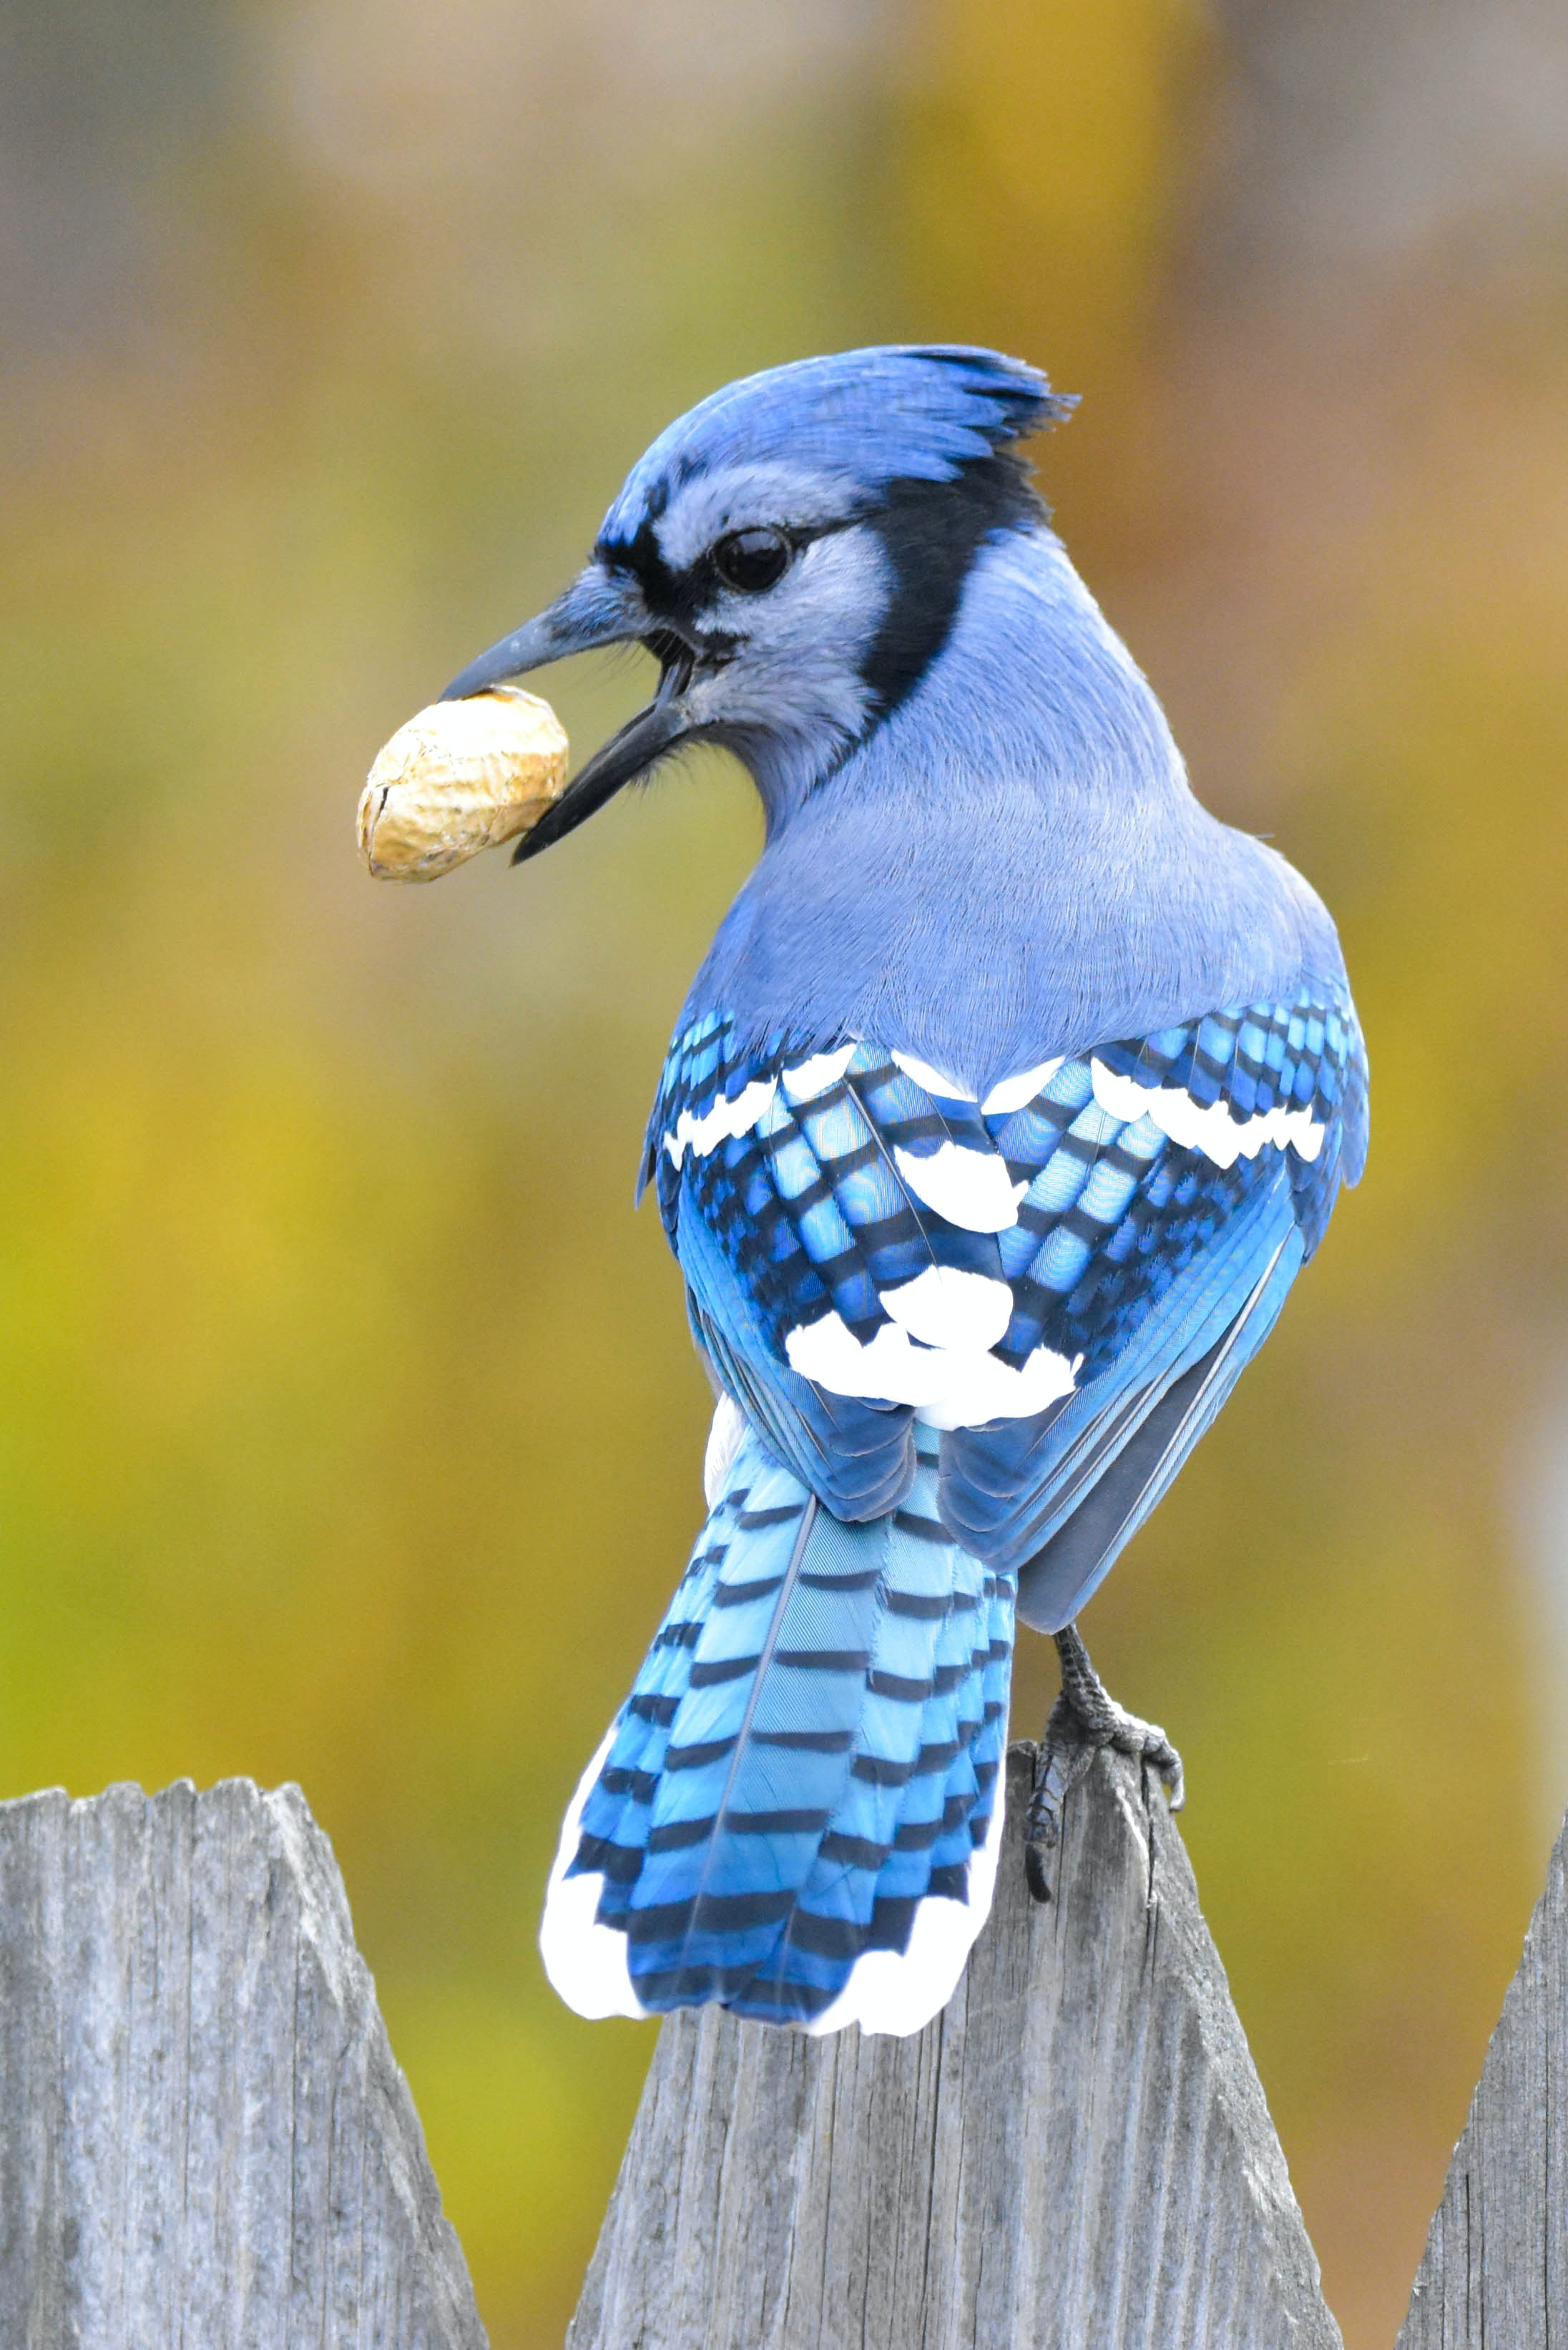

In [15]:
from IPython.display import Image
Image('images/index/'+result_filename, width=400)
